In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import json
import seaborn as sns
import time
import itertools
import cProfile
from torch.utils.checkpoint import checkpoint
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation & Preprocessing

In [ ]:
def load_configs(filename):
    with open(f'/content/drive/My Drive/{filename}.json', 'r') as file:
        return json.load(file)

In [ ]:
# Plot functions
def plot_last_prices(last_prices, normalized=True):
    plt.figure(figsize=(10, 5))
    plt.plot(last_prices, label='Normalized Prices')
    plt.legend()
    plt.ylabel('Normalized Price' if normalized else 'Price')
    plt.xlabel('Time Index')
    plt.title('Relative Change Rates of Close Prices' if normalized else 'Close Prices')
    plt.show()

def plot_volume(data, title):
    plt.figure(figsize=(10, 5))
    plt.plot(data['datetime'], data['volume'])
    plt.xlabel('Date')
    plt.ylabel('Trade Volume')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_prices_with_ma(data, period, period_labels):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['last_price'], label='Last Price')
    for i in range(len(period)):
      t = period[i]
      period_label = period_labels[i]
      plt.plot(data.index, data[f'ma({t})'], label=f'{period_label} MA')
    plt.xlabel('Date')
    plt.ylabel('Last Price')
    plt.title('Prices with Moving Average')
    plt.legend()
    plt.show()

def plot_prices_with_macd(data, short_period, long_period, signal_period):
    for i in range(len(short_period)):
      plt.figure(figsize=(10, 5))
      a = short_period[i]
      b = long_period[i]
      c = signal_period[i]
      plt.plot(data.index, data[f'macd_line({a},{b},{c})'], label=f'MACD')
      plt.plot(data.index, data[f'signal_line({a},{b},{c})'], label=f'Signal')
      plt.plot(data.index, data[f'macd_histogram({a},{b},{c})'], label=f'Histogram')
      plt.xlabel('Date')
      plt.ylabel('Convergence/Divergence')
      plt.title(f"MACD({a},{b},{c})")
      plt.legend()
      plt.show()

In [ ]:
# Moving Average (MA)
def moving_average(last_prices, num_periods):
    ma = last_prices.rolling(window=num_periods, min_periods=1).mean()
    # Forward fill the first num_periods-1 NaN values with the first non-NaN value
    ma.ffill(inplace=True)
    return ma

def calculate_ema(data, period):
    alpha = 2 / (period + 1)
    ema = [data.iloc[0]]  # EMA starts with the first data point

    for price in data.iloc[1:]:
        ema.append(alpha * price + (1 - alpha) * ema[-1])

    return pd.Series(ema, index=data.index)

# Moving Average Convergence/Divergence (MACD)
def calculate_macd(data, short_period, long_period, signal_period):
    short_ema = calculate_ema(data, short_period)
    long_ema = calculate_ema(data, long_period)

    macd_line = short_ema - long_ema
    signal_line = calculate_ema(macd_line, signal_period)
    macd_histogram = macd_line - signal_line

    return macd_line, signal_line, macd_histogram

In [ ]:
def filter_data_by_intervals(data, intervals):
    # Initialize a mask with False values
    interval_mask = pd.Series([False] * len(data))

    # Iterate over intervals and apply masks
    for start, end in intervals:
        start_time = pd.to_datetime(start).time()
        end_time = pd.to_datetime(end).time()

        # Create masks for start and end times
        start_time_mask = (data['datetime'].dt.time >= start_time)
        end_time_mask = (data['datetime'].dt.time <= end_time)

        # Combine masks based on interval crossing midnight or not
        if start_time <= end_time:
            interval_mask |= (start_time_mask & end_time_mask)
        else:
            interval_mask |= (start_time_mask | end_time_mask)

    # Apply the final mask to filter the data
    data_filtered = data[interval_mask]
    return data_filtered

def assert_time_intervals(df, intervals):
    df.index = pd.to_datetime(df.index)
    times = df.index.time

    time_intervals = [(pd.Timestamp(start).time(), pd.Timestamp(end).time()) for start, end in intervals]

    def is_within_intervals(t):
        return any(start <= t <= end if start <= end else start <= t or t <= end for start, end in time_intervals)

    outside_intervals = ~np.vectorize(is_within_intervals)(times)

    if outside_intervals.any():
        print("There are times outside the specified intervals:")
        print(df[outside_intervals])
    else:
        print("All times are within the specified intervals.")

    assert(not outside_intervals.any())

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def extract_main_contract(data_filtered, window=1000, min_periods=1, quantile=0.80):
    # Compute the rolling mean of volume
    data_filtered['volume_rolling'] = data_filtered['volume'].rolling(window=window, min_periods=min_periods).mean()

    # Calculate the volume threshold based on the quantile
    volume_threshold = data_filtered['volume_rolling'].quantile(quantile)

    # Identify high volume segments
    data_filtered['high_volume'] = data_filtered['volume_rolling'] > volume_threshold

    # Segment identification by cumulative sum of changes in high_volume status
    data_filtered['segment'] = data_filtered['high_volume'].ne(data_filtered['high_volume'].shift()).cumsum()

    # Filter the high volume segments and fill NaN values
    high_volume_segments = data_filtered[data_filtered['high_volume']]
    high_volume_segments['volume'] = high_volume_segments['volume'].ffill()

    # Drop the temporary columns
    high_volume_segments.drop(columns=['high_volume', 'segment', 'volume_rolling'], inplace=True)

    return high_volume_segments


def normalize_prices(data_array, intervals, timestamps, num_steps, input_size, last_price_index=0):
    # Convert timestamps to time objects
    timestamp_times = timestamps.time

    # Create an empty array to collect normalized prices
    normalized_last_price = np.full(len(data_array), np.nan)  # Use NaN to identify unassigned values

    for start, end in intervals:
        start_time = pd.Timestamp(start).time()
        end_time = pd.Timestamp(end).time()

        # Create masks for the interval
        start_mask = timestamp_times >= start_time
        end_mask = timestamp_times <= end_time
        if start_time <= end_time:
            interval_mask = start_mask & end_mask
        else:
            interval_mask = start_mask | end_mask

        # Filter data by interval
        interval_data = data_array[interval_mask]
        clear_gpu_cache()
        if len(interval_data) == 0:
            continue


        num_windows = (len(interval_data) + input_size - 1) // input_size
        windows = np.array_split(interval_data, num_windows)

        # Create array to hold normalized values for the current interval
        interval_normalized_last_price = np.full(len(interval_data), np.nan)

        start_idx = 0
        for window_data in windows:
            if len(window_data) == 0:
                continue

            if start_idx == 0:
                window_first_price = window_data[0, last_price_index]
                values = window_data[:, last_price_index] / window_first_price - 1.0
            else:
                window_last_price = window_data[-1, last_price_index]
                values = window_data[:, last_price_index] / window_last_price - 1.0

            end_idx = start_idx + len(window_data)
            interval_normalized_last_price[start_idx:end_idx] = values
            start_idx = end_idx

        normalized_last_price[interval_mask] = interval_normalized_last_price

    # Set to the data array
    data_array[:, last_price_index] = normalized_last_price

    # Process all outliers - impute with its previous non-outlying value
    postprocess_outliers(data_array)

    # Check for NaN values
    if np.isnan(data_array[:, last_price_index]).any():
        raise ValueError("Data contains NaN values after normalization. Please check the normalization process.")

    return data_array


def postprocess_outliers(data, threshold=0.5):
    outlier_indices = np.where(np.abs(data[:, 0]) > threshold)[0]

    for idx in outlier_indices:
        previous_value_idx = idx - 1
        while data[previous_value_idx, 0] > threshold and previous_value_idx > 0:
            previous_value_idx -= 1
        data[idx, 0] = data[previous_value_idx, 0]

def roll_data(data_array, num_steps, input_size):
    # Roll data to reshape it into the 4D shape (N, num_steps, input_size, # features)
    data_array = [np.array(data_array[i * input_size: (i + 1) * input_size])
                  for i in range(len(data_array) // input_size)]
    data_array = np.stack(data_array)
    return data_array


# Generator function
def data_generator(data_array, indices, num_steps, batch_size, last_price_index=0):
    total_len = len(indices)
    for start_idx in range(0, total_len, batch_size):
        end_idx = min(start_idx + batch_size, total_len)
        batch_indices = indices[start_idx:end_idx]
        X_batch = np.array([data_array[i: i + num_steps] for i in batch_indices])
        y_batch = data_array[batch_indices + num_steps, :, last_price_index]
        yield X_batch, y_batch


# Train-test split function
def train_test_split(data_array, num_steps, input_size, val_split, test_split, last_price_index=0):
    # Calculate the total number of samples
    total_len = len(data_array) - num_steps

    X = np.empty((total_len, num_steps, input_size, data_array.shape[-1] - 1), dtype=np.float32)
    y = np.empty((total_len, num_steps), dtype=np.float32)

    for i in range(total_len):
        X[i] = data_array[i:i + num_steps, :, 1:]  # Exclude the last_price column (column 0)
        y[i] = data_array[i + 1:i + num_steps + 1, :, last_price_index]  # Store the last_price values

    # Check the shapes of X and y
    num_features = data_array.shape[-1] - 1  # Exclude the last_price column
    assert X.shape == (total_len, num_steps, input_size, num_features), f"X shape mismatch: {X.shape}"
    assert y.shape == (total_len, num_steps), f"y shape mismatch: {y.shape}"
    assert len(X) == len(y), "Number of samples in X and y must be equal"

    # Determine the split indices
    test_start = int(total_len * (1 - test_split))
    val_start = int(total_len * (1 - test_split - val_split))

    # Split the data
    X_train, X_val, X_test = X[:val_start], X[val_start:test_start], X[test_start:]
    y_train, y_val, y_test = y[:val_start], y[val_start:test_start], y[test_start:]

    return X_train, y_train, X_val, y_val, X_test, y_test

def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    normalized_df = pd.DataFrame(normalized_data, index=data.index, columns=data.columns)
    return normalized_df

class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, num_steps, last_price_index):
        self.data = data
        self.num_steps = num_steps
        self.last_price_index = last_price_index
        self.num_features = data.shape[-1] - 1  # Exclude the last_price column

    def __len__(self):
        return len(self.data) - self.num_steps

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.num_steps, :, 1:], dtype=torch.float32)  # Exclude the last_price column (column 0)
        y = torch.tensor(self.data[idx + self.num_steps, :, self.last_price_index], dtype=torch.float32)
        return x, y

# Create dataloader instances
def create_dataloader_instances(dataset, val_split, test_split, batch_size, num_workers=2):
    dataset_size = len(dataset)
    test_size = int(test_split * dataset_size)
    val_size = int(val_split * (dataset_size - test_size))
    train_size = dataset_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

# Create forward fill bid custom
def forward_fill_bid_custom(data, price_cols):
    # Forward fill NaN values across rows for specified columns
    data[price_cols] = data[price_cols].ffill(axis=1)

    # Forward fill NaN values across columns for specified columns
    data[price_cols] = data[price_cols].ffill(axis=0)

    return data

def clear_gpu_cache():
    torch.cuda.empty_cache()


# Create sequences based on the extended_segment
def create_sequences(extended_segment, num_steps, input_size, normalize, val_split=0.1, test_split=0.1, batch_size=64):
    # Ensure no NaN values
    assert(np.isnan(extended_segment).sum().sum() == 0)

    # Setup
    timestamps = extended_segment.index
    extended_segment = extended_segment.to_numpy()
    last_price_index = 0

    # Prevent a division by 0 by imputing 0s to a very small number
    extended_segment[:, last_price_index] = np.where(extended_segment[:, last_price_index] == 0, 1e-6, extended_segment[:, last_price_index])

    # Plot the prices before normalization
    plot_last_prices(extended_segment[:, last_price_index], normalized=False)

    # Normalize prices - retrieve relative change rates
    if normalize:
        extended_segment = normalize_prices(extended_segment, intervals, timestamps, num_steps, input_size, last_price_index)

    clear_gpu_cache()

    # Plot the prices after normalization
    plot_last_prices(extended_segment[:, last_price_index])

    # Roll data for RNN
    extended_segment = roll_data(extended_segment, num_steps, input_size)
    clear_gpu_cache()

    # Create dataset and dataloader instances
    dataset = TimeSeriesDataset(extended_segment, num_steps, last_price_index)
    clear_gpu_cache()
    train_loader, val_loader, test_loader = create_dataloader_instances(dataset, val_split=val_split, test_split=test_split, batch_size=batch_size)
    clear_gpu_cache()

    return extended_segment, train_loader, val_loader, test_loader, dataset.num_features


def add_factors(extended_segment, short_period, long_period, signal_period, period):
    # Forward fill nan values in bid_prices (NOTE: This may not reflect the changes in market!)
    bid_price_cols = ['bid_price1', 'bid_price2', 'bid_price3', 'bid_price4', 'bid_price5']
    extended_segment = forward_fill_bid_custom(extended_segment, bid_price_cols)

    # Bid & Ask Volumes
    bid_volume_cols = ['bid_volume1', 'bid_volume2', 'bid_volume3', 'bid_volume4', 'bid_volume5']
    ask_volume_cols = ['ask_volume1', 'ask_volume2', 'ask_volume3', 'ask_volume4', 'ask_volume5']

    # Calculate Bid-Ask Spread
    extended_segment['bid_ask_spread'] = extended_segment['ask_price1'] - extended_segment['bid_price1']

    # Calculate Market Depth (total bid and ask volumes)
    extended_segment['total_bid_volume'] = extended_segment[bid_volume_cols].sum(axis=1)
    extended_segment['total_ask_volume'] = extended_segment[ask_volume_cols].sum(axis=1)

    # Calculate Order Imbalance
    extended_segment['order_imbalance'] = extended_segment['total_bid_volume'] - extended_segment['total_ask_volume']

    # Compute Factors: MA & MACD
    for i in range(len(period)):
      # Calculate MA
      t = period[i]
      extended_segment[f'ma({t})'] = moving_average(extended_segment['last_price'], t)
      extended_segment[f'ma({t})'] = extended_segment[f'ma({t})'].fillna(method='ffill')

      # Calculate MACD
      a = short_period[i]
      b = long_period[i]
      c = signal_period[i]
      macd_line, signal_line, macd_histogram = calculate_macd(extended_segment['last_price'], a, b, c)
      extended_segment[f'macd_line({a},{b},{c})'] = macd_line
      extended_segment[f'signal_line({a},{b},{c})'] = signal_line
      extended_segment[f'macd_histogram({a},{b},{c})'] = macd_histogram

    # print(pd.isna(extended_segment).sum())

All times are within the specified intervals.


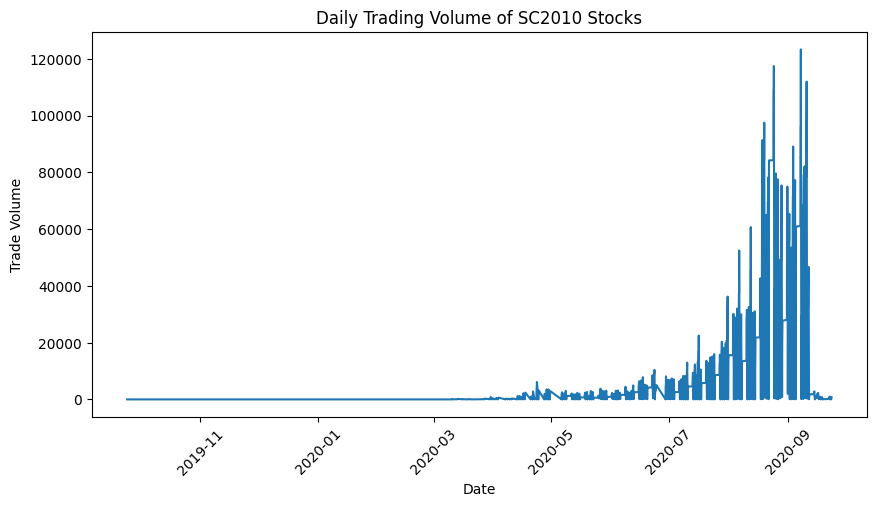

<ipython-input-6-643582a2f23a>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['volume_rolling'] = data_filtered['volume'].rolling(window=window, min_periods=min_periods).mean()
<ipython-input-6-643582a2f23a>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['high_volume'] = data_filtered['volume_rolling'] > volume_threshold
<ipython-input-6-643582a2f23a>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

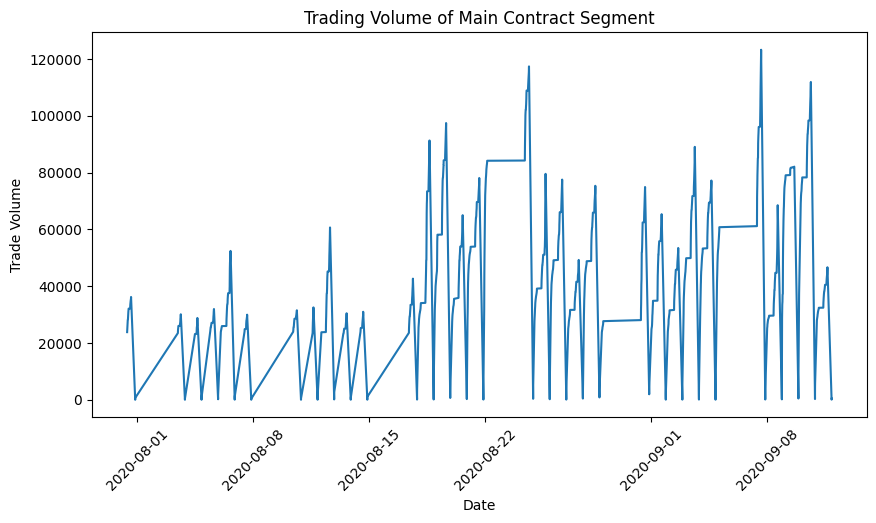

All times are within the specified intervals.


<ipython-input-6-643582a2f23a>:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[price_cols] = data[price_cols].ffill(axis=1)
<ipython-input-6-643582a2f23a>:260: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[price_cols] = data[price_cols].ffill(axis=0)
<ipython-input-6-643582a2f23a>:316: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

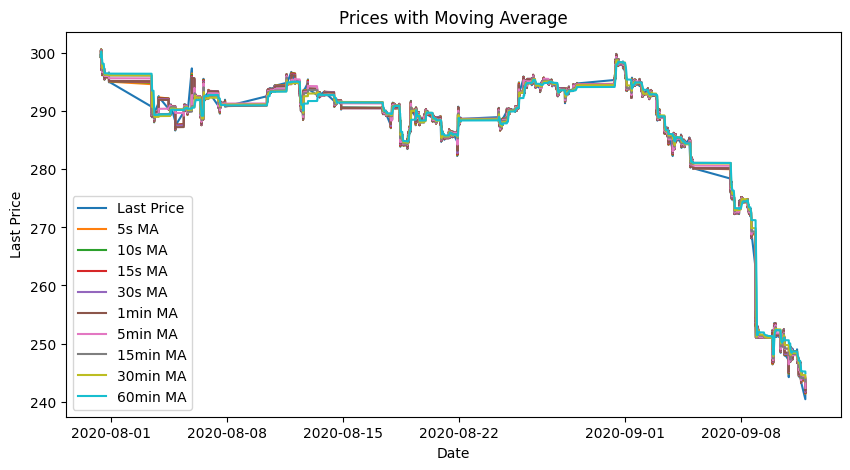

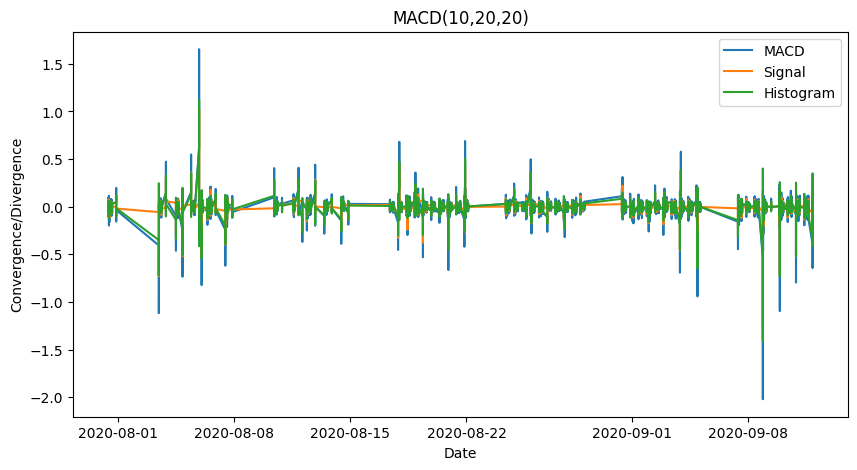

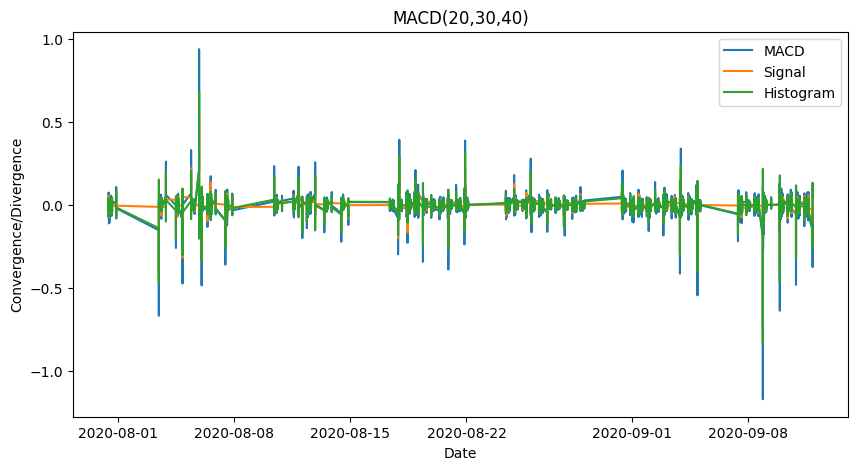

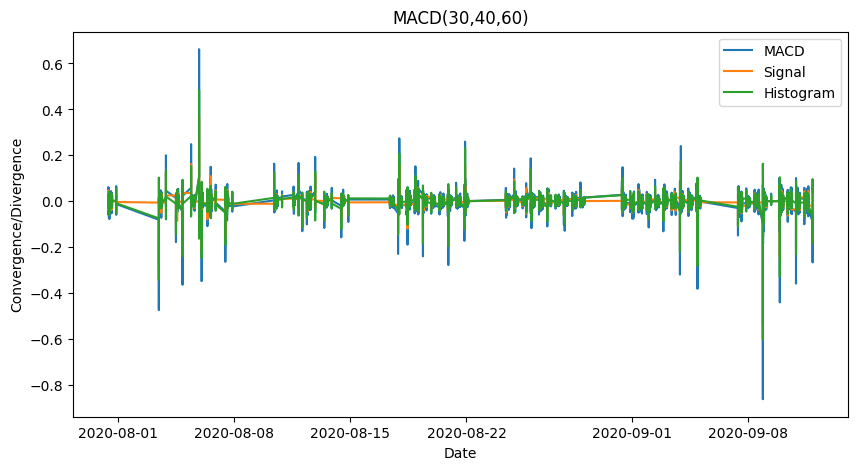

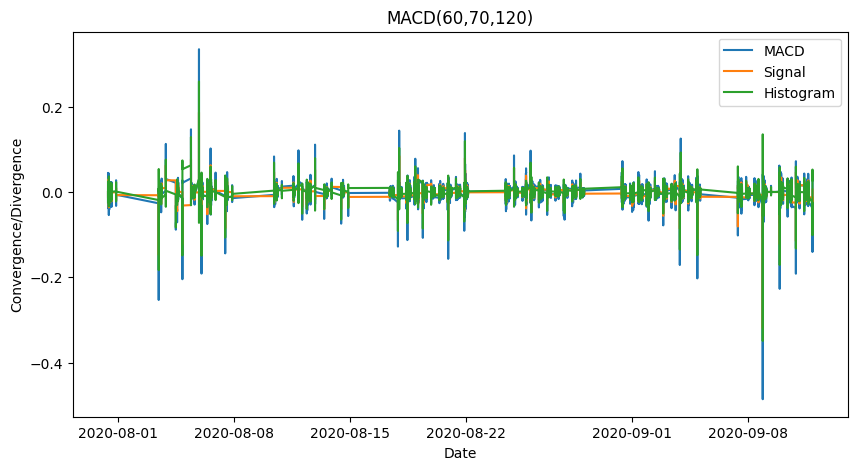

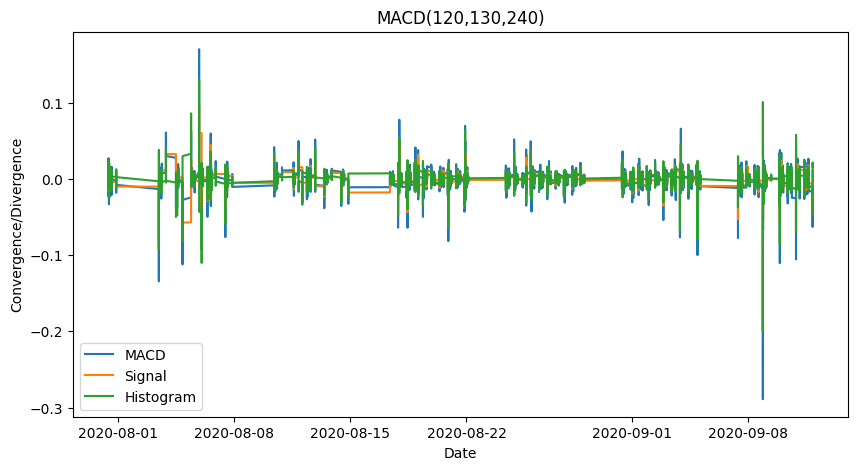

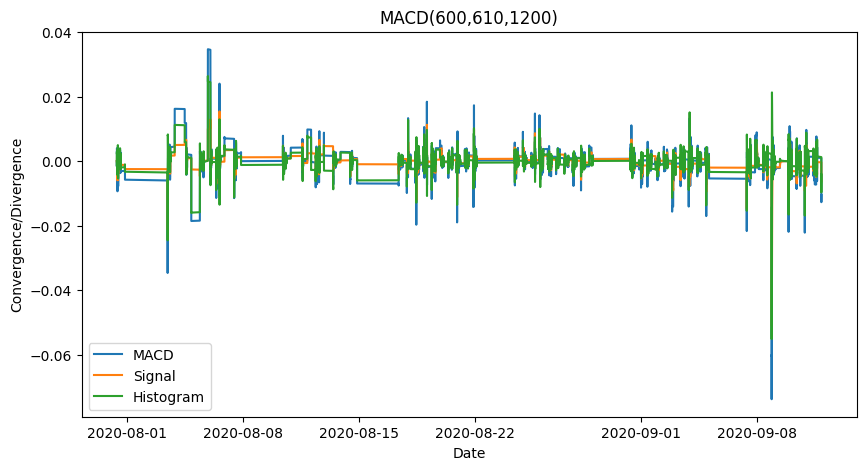

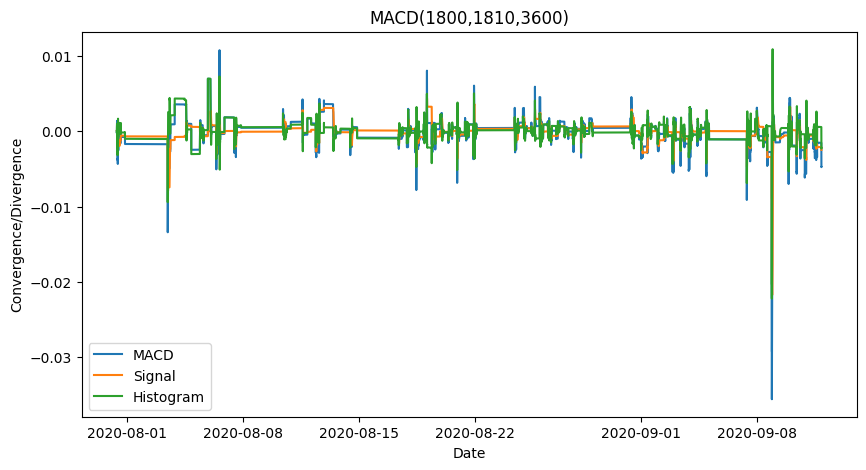

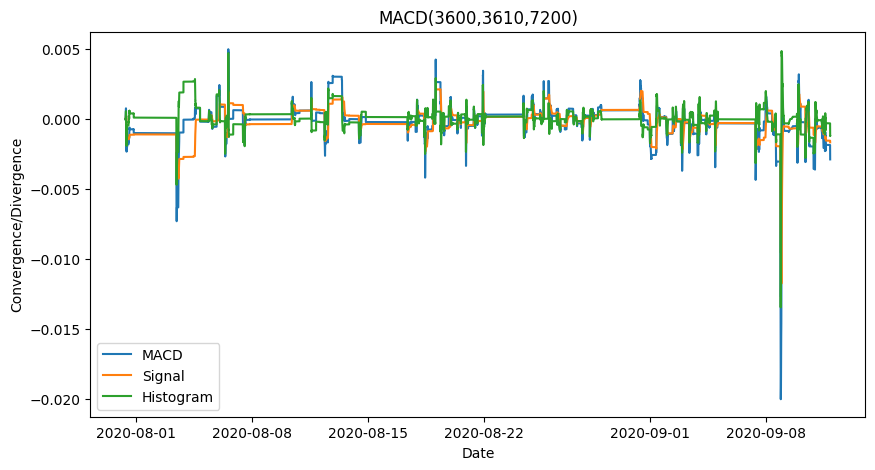

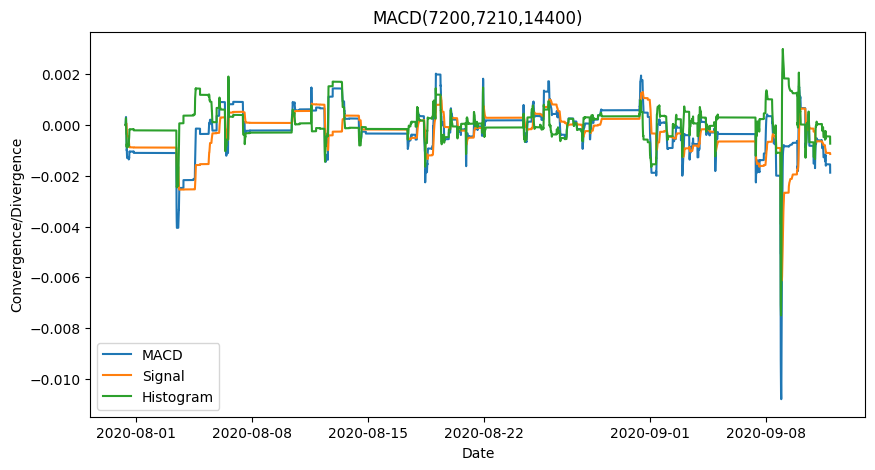

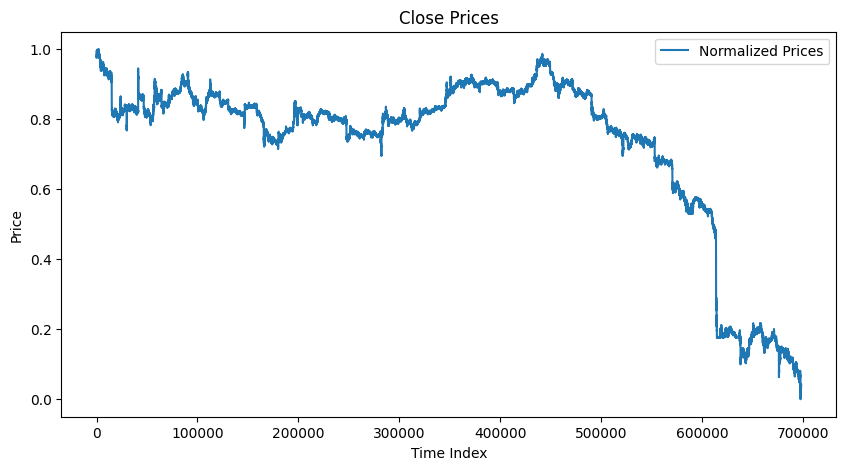

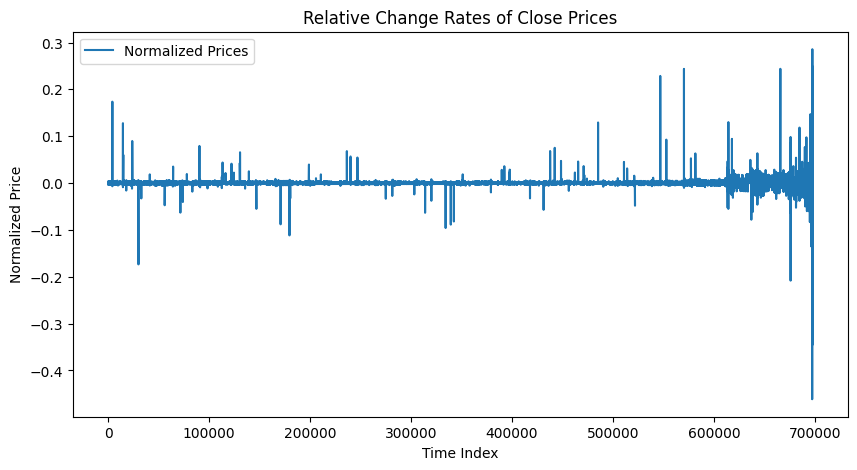

In [ ]:
# Params
dataset_filename = 'INE.sc2010'
intervals = [
    ('21:00:00', '02:30:00'),
    ('09:00:00', '10:15:00'),
    ('10:30:00', '11:30:00'),
    ('13:30:00', '15:00:00')
]
configs_filename = 'configs'

# Load configs file
configs = load_configs(configs_filename)
clear_gpu_cache()

# Read data
# data = pd.read_csv('data/' + dataset_filename + '.csv')
data = pd.read_csv(f'/content/drive/My Drive/{dataset_filename}.csv')
data['datetime'] = pd.to_datetime(data['datetime'])

# Set seed
set_seed(42)

with cProfile.Profile() as pr:
    # Only include data within the specified intervals
    data_filtered = filter_data_by_intervals(data, intervals)
    # pr.print_stats()

    # Make sure there are no values outside the given time intervals
    assert_time_intervals(data_filtered, intervals)
    # pr.print_stats()

    # Plot trading volume data
    plot_volume(data_filtered, 'Daily Trading Volume of SC2010 Stocks')

    # Extract the main contract
    # data_filtered = data_filtered.copy() # Avoid SettingWithCopyWarning
    # pr.print_stats()
    data_filtered.iloc[:, 1:] = data_filtered.iloc[:, 1:].astype(np.float32)
    # pr.print_stats()
    extended_segment = extract_main_contract(data_filtered)
    # pr.print_stats()

    # Plot main contract segment
    plot_volume(extended_segment, 'Trading Volume of Main Contract Segment')
    # pr.print_stats()

    # Set index of the resulting dataframe
    extended_segment.set_index('datetime', inplace=True)
    # pr.print_stats()

    # Make sure there are no values outside the given time intervals
    assert_time_intervals(extended_segment, intervals)
    # pr.print_stats()

    # Extract needed hyperparams
    input_size = configs['input_size']
    num_steps = configs['num_steps']
    normalize = configs['normalize']
    batch_size = configs['batch_size']

    # Add factors
    period_labels = np.array(['5s', '10s', '15s', '30s', '1min', '5min', '15min', '30min', '60min'])
    period = np.array([10, 20, 30, 60, 120, 600, 1800, 3600, 7200])
    short_period = period
    long_period = period + 10
    signal_period = 2 * period

    add_factors(extended_segment, short_period, long_period, signal_period, period)
    # pr.print_stats()

    # Plot closing prices with factors
    plot_prices_with_ma(extended_segment, period, period_labels)
    plot_prices_with_macd(extended_segment, short_period, long_period, signal_period)

    # Normalize data
    extended_segment = normalize_data(extended_segment)
    # pr.print_stats()
    assert(extended_segment.isna().sum().sum() == 0)

    # Create sequences based on the extended_segment
    extended_segment, train_loader, val_loader, test_loader, num_features = create_sequences(extended_segment, num_steps, input_size, normalize, val_split=0.1, test_split=0.1, batch_size=batch_size)

## Model Definition: LSTM Cell

In [ ]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(CustomLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_i = nn.Parameter(torch.randn(input_size, hidden_dim))
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))

        self.W_f = nn.Parameter(torch.randn(input_size, hidden_dim))
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))

        self.W_c = nn.Parameter(torch.randn(input_size, hidden_dim))
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_c = nn.Parameter(torch.zeros(hidden_dim))

        self.W_o = nn.Parameter(torch.randn(input_size, hidden_dim))
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))

        # Layer normalization layers
        self.ln_i = nn.LayerNorm(hidden_dim)
        self.ln_f = nn.LayerNorm(hidden_dim)
        self.ln_c = nn.LayerNorm(hidden_dim)
        self.ln_o = nn.LayerNorm(hidden_dim)

        self.init_weights()

        # Check that all params require gradients
        for name, param in self.named_parameters():
          if not param.requires_grad:
              print(f"{name} does not require grad")

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.orthogonal_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            assert(not torch.isnan(param).any())

    def forward(self, x, h, c):
        i_t = torch.sigmoid(self.ln_i(torch.matmul(x, self.W_i) + torch.matmul(h, self.U_i) + self.b_i))
        f_t = torch.sigmoid(self.ln_f(torch.matmul(x, self.W_f) + torch.matmul(h, self.U_f) + self.b_f))
        g_t = torch.tanh(self.ln_c(torch.matmul(x, self.W_c) + torch.matmul(h, self.U_c) + self.b_c))
        o_t = torch.sigmoid(self.ln_o(torch.matmul(x, self.W_o) + torch.matmul(h, self.U_o) + self.b_o))

        c_t = f_t * c + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        assert(not torch.isnan(h_t).any())
        assert(not torch.isnan(c_t).any())

        return h_t, c_t

## Model Definition: GRU Cell

In [ ]:
class CustomGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomGRUCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Initialize weights and biases
        self.W_z = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_z = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_r = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_r = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_h = nn.Parameter(torch.randn(input_dim, hidden_dim).float())
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_h = nn.Parameter(torch.zeros(hidden_dim).float())

        # Layer normalization layers
        self.ln_z = nn.LayerNorm(hidden_dim)
        self.ln_r = nn.LayerNorm(hidden_dim)
        self.ln_h = nn.LayerNorm(hidden_dim)

        self.init_weights()

        # Check that all params require gradients
        for name, param in self.named_parameters():
          if not param.requires_grad:
              print(f"{name} does not require grad")

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.xavier_uniform_(param)  # Use orthogonal initialization
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)

            # Check for NaN values
            assert(not torch.isnan(param).any())

    def forward(self, x, h):
        z_t = torch.sigmoid(self.ln_z(torch.mm(x, self.W_z) + torch.mm(h, self.U_z) + self.b_z))
        r_t = torch.sigmoid(self.ln_r(torch.mm(x, self.W_r) + torch.mm(h, self.U_r) + self.b_r))
        h_hat_t = torch.tanh(self.ln_h(torch.mm(x, self.W_h) + torch.mm(r_t * h, self.U_h) + self.b_h))

        h_t = (1 - z_t) * h + z_t * h_hat_t

        assert(not torch.isnan(h_t).any())

        return h_t

## Model Definition: RNN with Checkpoints (for Memory Optimization)

In [ ]:
class CustomRNNModel(nn.Module):
    def __init__(self, input_size, num_features, hidden_dim, output_dim, num_layers, dropout_rate, dense_units, cell_type='lstm'):
        super(CustomRNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.cell_type = cell_type
        self.input_dim = input_size * num_features
        self.num_features = num_features

        if cell_type == 'lstm':
            self.layers = nn.ModuleList([CustomLSTMCell(self.input_dim, hidden_dim)])
            self.layers.extend([CustomLSTMCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        elif cell_type == 'gru':
            self.layers = nn.ModuleList([CustomGRUCell(self.input_dim, hidden_dim)])
            self.layers.extend([CustomGRUCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)])
        else:
            raise ValueError("Unsupported cell type")

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_dim, dense_units)
        self.fc2 = nn.Linear(dense_units, output_dim)

    def forward(self, x):
        batch_size, num_steps, input_size, num_features = x.size()
        # print(f"x.size(): {x.size()}")  # Debug print
        assert input_size * num_features == self.input_dim, f"Input dimension mismatch: {input_size * num_features} != {self.input_dim}"

        x = x.view(batch_size, num_steps, -1)  # Flatten the input dimensions to (batch_size, num_steps, input_size * num_features)
        # print(f"x.view size: {x.size()}")  # Debug print

        h_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]
        if self.cell_type == 'lstm':
            c_t = [torch.zeros(batch_size, self.hidden_dim, device=x.device) for _ in range(self.num_layers)]

        for t in range(num_steps):
            x_t = x[:, t, :]
            # print(f"x_t size at time step {t}: {x_t.size()}")  # Debug print
            for layer in range(self.num_layers):
                if self.cell_type == 'lstm':
                    h_t[layer], c_t[layer] = self.layers[layer](x_t, h_t[layer], c_t[layer])
                else:
                    h_t[layer] = self.layers[layer](x_t, h_t[layer])
                x_t = h_t[layer]
                # print(f"h_t size after layer {layer} at time step {t}: {h_t[layer].size()}")  # Debug print

        x = self.dropout(x_t)
        # print(f"After dropout: {x.size()}")  # Debug print
        x = torch.relu(self.fc1(x))
        # print(f"After fc1: {x.size()}")  # Debug print
        x = self.fc2(x)
        # print(f"After fc2: {x.size()}")  # Debug print

        return x

In [ ]:
class CheckpointedRNN(nn.Module):
    def __init__(self, *args, **kwargs):
        super(CheckpointedRNN, self).__init__()
        self.model = CustomRNNModel(*args, **kwargs)

    def forward(self, x):
        def custom_forward(*inputs):
            return self.model(*inputs)

        return checkpoint(custom_forward, x, use_reentrant=False)

## Model Definition: Model Ensembling

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, model_class, num_models, *args, **kwargs):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList([model_class(*args, **kwargs) for _ in range(num_models)])

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.stack(outputs, dim=0)

## RNN Model Training

In [ ]:
def quantile_loss(outputs, targets, quantile=0.5):
    errors = targets - outputs
    loss = torch.max((quantile - 1) * errors, quantile * errors)
    return torch.mean(loss)

class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()

    def forward(self, outputs, targets):
        return torch.mean(torch.clamp(1 - targets * outputs, min=0))

def directional_loss(outputs, targets):
    return torch.mean(torch.abs(torch.sign(outputs) - torch.sign(targets)))

def choose_loss_function(loss, quantile=None):
    if loss == 'huber':
        criterion = nn.SmoothL1Loss()
    elif loss == 'mse':
        criterion = nn.MSELoss()
    elif loss == 'quantile' and quantile is not None:
        criterion = lambda outputs, targets: quantile_loss(outputs, targets, quantile=quantile)
    elif loss == 'hinge':
        criterion = HingeLoss()
    elif loss == 'directional':
        criterion = directional_loss
    else:
        raise ValueError("Unsupported loss function")

    return criterion

In [ ]:
def train_model(model, train_loader, val_loader, criterion, init_epochs, num_epochs, init_learning_rate, learning_rate_decay, device, cell_type, early_stop_patience, accumulation_steps=4):
    optimizer = optim.Adam(model.parameters(), lr=init_learning_rate)
    scaler = torch.cuda.amp.GradScaler()

    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    # Assert: All model parameters require a grad
    for name, param in model.named_parameters():
        assert(param.requires_grad)

    # print("\nSTART OF TRAINING")
    for epoch in tqdm(range(num_epochs), position=0, leave=True):
        # Train Model
        model.train()

        # Set learning rates
        current_lr = init_learning_rate * (learning_rate_decay ** max(float(epoch + 1 - init_epochs), 0.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr


        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # print(f"Epoch {epoch} - 1")
        for i, (inputs, targets) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', position=0, leave=True)):
            inputs, targets = inputs.to(device), targets.to(device)
            inputs.requires_grad = True
            targets.requires_grad = True

            # print(f"Batch {i} - 1")
            optimizer.zero_grad()
            # print(f"Batch {i} - 2")

            with torch.no_grad():
                with torch.cuda.amp.autocast():
                    # print(f"Batch {i} - 2a")
                    outputs = model(inputs)
                    # print(f"Batch {i} - 2b")
                    loss = criterion(outputs, targets)
                    # print(f"Batch {i} - 2c")
                    loss = loss / accumulation_steps
                    # print(f"Batch {i} - 2d")

            loss.requires_grad = True
            outputs.requires_grad = True
            # print(f"Batch {i} - 3")


            scaler.scale(loss).backward()

            # print(f"Batch {i} - 4")

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            # print(f"Batch {i} - 5")

            epoch_train_loss += loss.item() * accumulation_steps

            # print(f"Batch {i} - 6")


        # print(f"Epoch {epoch} - 2")
        train_losses.append(epoch_train_loss / len(train_loader))
        # print(f"Epoch {epoch} - 3")

        model.eval()

        # print(f"Epoch {epoch} - 4")
        with torch.no_grad():
            for inputs, targets in val_loader:
                # print(f"Val Eval - 1")
                inputs, targets = inputs.to(device), targets.to(device)

                # print(f"Val Eval - 2")
                with torch.cuda.amp.autocast():
                    # print(f"Val Eval - 2a")
                    outputs = model(inputs)
                    # print(f"Val Eval - 2b")
                    loss = criterion(outputs, targets)
                    # print(f"Val Eval - 2c")

                # print(f"Val Eval - 3")

                epoch_val_loss += loss.item()

                # print(f"Val Eval - 4")

        # print(f"Epoch {epoch} - 5")
        val_losses.append(epoch_val_loss / len(val_loader))
        # print(f"Epoch {epoch} - 6")

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        # print(f"Epoch {epoch} - 7")

        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch}")
            break

        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")


    # print(f"ALMOTST FINISHED")
    model.load_state_dict(best_model_state)
    # print(f"FINISHED!")

    return model, train_losses, val_losses


def load_model(model, cell_type, device):
    model_path = f'models/SP500_{cell_type}_model.pth'
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

In [ ]:
def train(configs, criterion, cell_type):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    input_size = configs['input_size']
    num_steps = configs['num_steps']
    num_units = configs[cell_type][cell_type + '_units']
    num_layers = configs[cell_type][cell_type + '_layers']
    dropout_rate = configs[cell_type]['dropout_rate']
    dense_units = configs[cell_type]['dense_units']
    init_learning_rate = configs[cell_type]['init_learning_rate']
    learning_rate_decay = configs[cell_type]['learning_rate_decay']
    init_epochs = configs[cell_type]['init_epochs']
    max_epochs = configs[cell_type]['max_epochs']
    early_stop_patience = configs[cell_type].get('early_stop_patience', None)
    train_needed = configs[cell_type]['pretrain']

    batch_size = configs['batch_size']

    model = CheckpointedRNN(input_size=input_size, num_features=num_features, hidden_dim=num_units, output_dim=input_size, num_layers=num_layers, dropout_rate=dropout_rate, dense_units=dense_units, cell_type=cell_type)
    model.to(device)

    if train_needed:
        start_time = time.time()

        model, train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, init_epochs, max_epochs, init_learning_rate, learning_rate_decay, device, cell_type, early_stop_patience)

        duration = time.time() - start_time
        torch.save(model.state_dict(), f'models/SP500_{cell_type}_model.pth')

        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    return model

In [ ]:
# Assume extended_segment is a NumPy array or similar structure
criterion = choose_loss_function('huber')
cell_type = 'lstm'

# Training
model, duration = train(configs, criterion, cell_type)
print(f"Training duration: {duration} seconds")

/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/5863 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch [0/50], Train Loss: 0.008361326717300924, Val Loss: 0.006077986641964115


Epoch 2/50:   0%|          | 0/5863 [00:00<?, ?it/s]

## RNN Model Evaluation

In [ ]:
def make_predictions(model, data_loader, device, criterion):
    model.eval()
    predictions = []
    actuals = []
    test_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            predictions.append(outputs.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
            test_loss += criterion(outputs, y_batch).item()

    test_loss /= len(data_loader)
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    return np.array(predictions).flatten(), np.array(actuals).flatten(), test_loss

def calculate_accuracy(predictions, actuals):
    correct = np.sum(np.sign(predictions) == np.sign(actuals))
    print("correct:", correct)
    total = len(actuals)
    print("total:", total)
    accuracy = correct / total
    return accuracy

 # Plot the predictions against the actual values
def plot_results(input_size, num_steps, actuals, predictions):
    plt.figure(figsize=(10, 5))
    x = np.arange(len(actuals))
    plt.bar(x - 0.2, actuals, label='Actual Prices')
    plt.bar(x + 0.2, predictions, label='Predicted Prices')
    plt.xlabel('Value')
    plt.ylabel('Normalized Price')
    plt.ylim(-0.1, 0.1)
    plt.title(f'Predicted vs Actual Prices for input_size={input_size}, num_steps={num_steps}')
    plt.legend()
    plt.show()

def predict(model, test_loader, input_size, num_steps, criterion):
    # GPU device if possible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Make predictions
    predictions, actuals, test_loss = make_predictions(model, test_loader, device, criterion)

    # Classification accuracy
    classification_accuracy = calculate_accuracy(predictions, actuals)

    # Plot results
    plot_results(input_size, num_steps, actuals, predictions)

    return test_loss, classification_accuracy

In [ ]:
# Prediction
test_loss, classification_accuracy = predict(model, test_loader, input_size, num_steps, criterion)
print(f"Test loss: {test_loss}")
print(f"Classification accuracy: {classification_accuracy}")